Что должно быть в проекте: 

Полностью или частично собраны данные. Реализована новая модель предсказания или построена новая модель симуляции. Проведено сравнение с существующими аналогами, проведен количественный/качественный анализ результатов. Подготовлен отчет о проделанной работе в формате исследовательской статьи `(research paper)` или технического отчета `(technical report)`, и воспроизводимый код по проекту.

Задача спарсить данные пользователей из группы в ВК про Валерия Меладзе: 
https://vk.com/meladze_valery

Провести анализ и обработку собранных данных (почистить данные, посмотреть есть ли пропуски), удалить лишние столбцы. Учитывая данные пользователей можно посмотреть каков средний возраст слушателей, из каких стран или регионов люди вступают в группу, также посмотреть какие есть общие группы, в которых пользователи пересекаются (определить топ групп или интересов). 
Сделать визуализацию по распределению пользователей по странам или по возрасту. 

1. На основе парсинга определить пользователей, которые не состоят ни в одной общей между собой группе, кроме группы фанов Меладзе. 
2. Найти еще около пяти пересекающихся групп, на которые подписано самое большое количество человек, следящих за творчеством Валерия Меладзе. Сделать визаулизацию (что-то типо диаграммы Венна). 


In [230]:
import vk
import time
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
vk_token = 'b7cef4cfb7cef4cfb7cef4cf80b7b47180bb7ceb7cef4cfd6726241a2ac634994769f05'

In [3]:
vk_token = '880c04e5e7b965a3b627525f1bdbc78cb58bf0adf3229737ecddd245385dd5680335fc9667c9163b72216'

In [101]:
vk_token = '61f834acf5f3577c9af490f02aa5cd6aa3b7ed6da86f7b7212832b03d2cb206b069776144cb5d0ff3cb3a'

# Выгрузим id всех пользователей из нужной нам группы

In [103]:
session_group = vk.Session(access_token=vk_token)

In [104]:
vk_api_group = vk.API(session_group)

In [105]:
vk_api_group.groups.getMembers(group_id='meladze_valery', v=5.92).keys()

dict_keys(['count', 'items'])

In [106]:
fields = ['bdate', 'city', 'country', 'last_seen', 'sex']

In [107]:
data = vk_api_group.groups.getMembers(group_id='meladze_valery', 
                                      v=5.92,
                                      fields=fields
                                      )['items']

In [108]:
count = vk_api_group.groups.getMembers(group_id='meladze_valery', v=5.92)["count"] // 1000

In [109]:
for i in range(1, count+1):  
    time.sleep(0.5)
    data = data + vk_api_group.groups.getMembers(group_id='meladze_valery', 
                                                 v=5.92, 
                                                 fields=fields,
                                                 offset=i*1000)["items"]

In [110]:
data[:3]

[{'first_name': 'Pervin',
  'id': 1820,
  'last_name': 'Mohammadzade',
  'can_access_closed': False,
  'is_closed': True,
  'sex': 2,
  'city': {'id': 1, 'title': 'Москва'},
  'country': {'title': 'Россия', 'id': 1},
  'last_seen': {'platform': 7, 'time': 1640007683}},
 {'first_name': 'Жаннет',
  'id': 4886,
  'last_name': 'Венжега',
  'can_access_closed': False,
  'is_closed': True,
  'sex': 1,
  'bdate': '7.3',
  'city': {'id': 2, 'title': 'Санкт-Петербург'},
  'country': {'title': 'Россия', 'id': 1},
  'last_seen': {'platform': 7, 'time': 1639571809}},
 {'first_name': 'Анастасия',
  'id': 11926,
  'last_name': 'Андреева',
  'deactivated': 'banned',
  'sex': 1}]

## Посмотрим на данные

In [111]:
df = pd.DataFrame(data)

In [112]:
df.sample(5)

,first_name,id,last_name,can_access_closed,is_closed,sex,city,country,last_seen,bdate,deactivated
7121,Ксения,28943623,Гальчанская,False,True,1,"{'id': 123, 'title': 'Самара'}","{'title': 'Россия', 'id': 1}","{'platform': 2, 'time': 1639506779}",20.11,NaN
26394,Юлия,282070613,Малышева,NaN,NaN,1,NaN,NaN,NaN,NaN,banned
13755,Ace,105722022,Ventura,False,True,2,"{'id': 2, 'title': 'Санкт-Петербург'}","{'title': 'Россия', 'id': 1}","{'platform': 7, 'time': 1640002692}",12.3.1986,NaN
29559,Алик,344507049,Даштамиров,True,False,2,"{'id': 5252, 'title': 'Шебекино'}","{'title': 'Россия', 'id': 1}","{'platform': 1, 'time': 1639984526}",NaN,NaN
12864,Ксения,92051452,Хасанченко,False,True,1,NaN,"{'title': 'Россия', 'id': 1}","{'platform': 4, 'time': 1640006964}",NaN,NaN


Оставим только существующие аккаунты

In [113]:
df = df[df['last_seen'].notna()]

In [114]:
df['last_seen'] = df['last_seen'].apply(lambda x: pd.to_datetime(x['time'], unit='s'))

In [115]:
df['bdate'] = df['bdate'].fillna('0')

In [116]:
def func(x):
    if len(x) > 7:
        return x
    else:
        return '0'

Достанем возраст

In [117]:
df['bdate_normal'] = df['bdate'].apply(lambda x: func(x))

In [118]:
def func2(x):
    if x != '0':
        return 2021-int(x[-4:])
    else:
        return 0

In [119]:
df['age'] = df['bdate_normal'].apply(lambda x: func2(x))

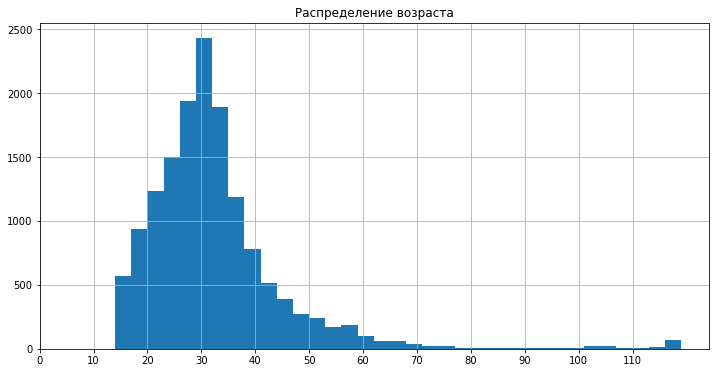

In [120]:
plt.figure(figsize=(12,6))

plt.hist(df[df['age'] != 0]['age'], bins=35)
plt.grid()
plt.title('Распределение возраста')
plt.xticks(range(0,120,10))
plt.show()

In [121]:
df['sex'].value_counts()

1    23030
2     9058
0       25
Name: sex, dtype: int64

Приведем колонки `city` и `country` в нормальный вид

In [122]:
def func3(x):
    try:
        return x['title']
    except:
        return x

In [123]:
df['city'] = df['city'].apply(lambda x: func3(x))
df['country'] = df['country'].apply(lambda x: func3(x))

In [124]:
df.loc[df['city'].notna(), 'city'].value_counts()[:8]

Москва             3167
Санкт-Петербург    2101
Киев                570
Минск               439
Екатеринбург        394
Казань              384
Краснодар           354
Алматы              354
Name: city, dtype: int64

In [125]:
df.sample(5)

,first_name,id,last_name,can_access_closed,is_closed,sex,city,country,last_seen,bdate,deactivated,bdate_normal,age
37882,Саша,610424494,Денисова,True,False,1,NaN,NaN,2021-12-20 05:11:12,24.9.2005,NaN,24.9.2005,16
36751,Валерия,563563932,Мартова,True,False,1,Москва,Россия,2021-09-07 22:08:15,0,NaN,0,0
27348,Қуандық,300755451,Бекзат,True,False,2,NaN,Казахстан,2021-07-18 09:52:13,0,NaN,0,0
9748,Тетяна,52425907,Романець,True,False,1,Луцк,Украина,2017-07-28 19:29:43,23.12.1992,NaN,23.12.1992,29
32877,Яна,430137934,Темникова,False,True,1,NaN,Россия,2021-12-20 13:40:42,16.4.2003,NaN,16.4.2003,18


Отлично. У нас есть все данные о пользователях в группе, но давайте теперь найдем список групп, в который каждый из этих пользователь состоит. Это делается с помощью метода `groups.get()`

# Достанем список групп для каждого пользователя

Достать данные о всех группах всех пользователей не получится, тк у vk стоит ограничение на количество запросов в сутки. Достанем сколько сможем. Чтобы данные были максимально подробные, попробуем достать сначала для тех, у кого есть все данные (возраст, пол и пр.)

In [136]:
ids_to_get = list(df.loc[df['age'] != 0, 'id'])

In [141]:
user_groups = []

In [142]:
for user_id in tqdm(ids_to_get):
    try:
        group_dict = {}
        group_dict['id'] = user_id
        group_dict['groups'] = vk_api_group.groups.get(v=5.92,
                               user_id = user_id,
                               extended = 1)['items']
        
        user_groups.append(group_dict)
    except:
        continue

100%|█████████████████████████████████████| 14728/14728 [52:31<00:00,  4.67it/s]


Выдается ошибка : `VkAPIError: 29. Rate limit reached.`

In [144]:
df_groups = pd.DataFrame(user_groups)

In [147]:
df_groups.loc[0, 'groups'][0]

{'id': 184706987,
 'name': 'MARVEL',
 'screen_name': 'marvel',
 'is_closed': 0,
 'type': 'page',
 'is_admin': 0,
 'is_member': 0,
 'is_advertiser': 0,
 'photo_50': 'https://sun1-28.userapi.com/s/v1/if1/5yTlVLsLD1CXyK_1zZn6Fi0dhZ4zzVM8V_EtKXQFXFKp0F7mY2l7Ar0xlA8WrsrkiVF1w_Pn.jpg?size=50x50&quality=96&crop=0,0,748,748&ava=1',
 'photo_100': 'https://sun1-28.userapi.com/s/v1/if1/dFbshaqcg_XxMD1sgOh18GN4De_V65SlZJtF6M_ME2lWDnItyfu6X3SKA2sYc1fvUS_dgVfs.jpg?size=100x100&quality=96&crop=0,0,748,748&ava=1',
 'photo_200': 'https://sun1-28.userapi.com/s/v1/if1/wNVYSG25pYRgYDrv5eGIracZibeugkOwpa5BogMNemvzxEUvGT4Epa_C8afxEYdjOn90BAWo.jpg?size=200x200&quality=96&crop=0,0,748,748&ava=1'}

In [145]:
df_groups

,id,groups
0,12631,"[{'id': 184706987, 'name': 'MARVEL', 'screen_n..."
1,17163,"[{'id': 37094684, 'name': 'ТОЛЬЯТТИ', 'screen_..."
2,22266,"[{'id': 31480508, 'name': 'Пикабу', 'screen_na..."
3,24276,"[{'id': 56106344, 'name': 'Палата №6', 'screen..."
4,43378,"[{'id': 43451713, 'name': 'Красиво!', 'screen_..."
...,...,...
4664,684678614,"[{'id': 184544773, 'name': 'Новости Прокопьевс..."
4665,684961536,"[{'id': 93965182, 'name': 'Юлианна Караулова',..."
4666,684983981,"[{'id': 22822305, 'name': 'ВКонтакте', 'screen..."
4667,685780451,"[{'id': 4336146, 'name': 'Валерий Меладзе', 's..."


In [150]:
df_groups = df_groups.explode('groups')

In [167]:
def func4(x):
    try:
        return x['id']
    except:
        return x

In [168]:
df_groups['group_id'] = df_groups['groups'].apply(lambda x: func4(x))

In [169]:
def func5(x):
    try:
        return x['name']
    except:
        return x

In [170]:
df_groups['name'] = df_groups['groups'].apply(lambda x: func5(x))

In [171]:
df_groups

,id,groups,group_id,name
0,12631,"{'id': 184706987, 'name': 'MARVEL', 'screen_na...",184706987.0,MARVEL
0,12631,"{'id': 23688663, 'name': 'Android Blog | Игры ...",23688663.0,Android Blog | Игры на Андроид
0,12631,"{'id': 147845620, 'name': 'VK Музыка', 'screen...",147845620.0,VK Музыка
0,12631,"{'id': 60394803, 'name': 'Traveler's blog', 's...",60394803.0,Traveler's blog
0,12631,"{'id': 33340946, 'name': 'Совкомбанк', 'screen...",33340946.0,Совкомбанк
...,...,...,...,...
4668,685972406,"{'id': 206215618, 'name': 'ЭкоПункт КИНЕЛЬ', '...",206215618.0,ЭкоПункт КИНЕЛЬ
4668,685972406,"{'id': 67235268, 'name': 'Знакомства в Куванды...",67235268.0,Знакомства в Кувандыке
4668,685972406,"{'id': 205324057, 'name': 'Вкусные и Полезные ...",205324057.0,Вкусные и Полезные Рецепты
4668,685972406,"{'id': 198339739, 'name': 'ГКОУ СКШИ село Зиян...",198339739.0,ГКОУ СКШИ село Зиянчурино


## Определить пользователей, которые не состоят ни в одной общей между собой группе, кроме группы фанов Меладзе

In [222]:
df_groups_2 = df_groups.copy()

In [232]:
df_groups_2 = df_groups_2[df_groups_2['name'].notna()]

In [237]:
df_groups_2 = df_groups_2[~df_groups_2['name'].str.contains('Меладзе')]

In [238]:
df_groups_2

,id,groups,group_id,name
0,12631,"{'id': 184706987, 'name': 'MARVEL', 'screen_na...",184706987.0,MARVEL
0,12631,"{'id': 23688663, 'name': 'Android Blog | Игры ...",23688663.0,Android Blog | Игры на Андроид
0,12631,"{'id': 147845620, 'name': 'VK Музыка', 'screen...",147845620.0,VK Музыка
0,12631,"{'id': 60394803, 'name': 'Traveler's blog', 's...",60394803.0,Traveler's blog
0,12631,"{'id': 33340946, 'name': 'Совкомбанк', 'screen...",33340946.0,Совкомбанк
...,...,...,...,...
4668,685972406,"{'id': 206215618, 'name': 'ЭкоПункт КИНЕЛЬ', '...",206215618.0,ЭкоПункт КИНЕЛЬ
4668,685972406,"{'id': 67235268, 'name': 'Знакомства в Куванды...",67235268.0,Знакомства в Кувандыке
4668,685972406,"{'id': 205324057, 'name': 'Вкусные и Полезные ...",205324057.0,Вкусные и Полезные Рецепты
4668,685972406,"{'id': 198339739, 'name': 'ГКОУ СКШИ село Зиян...",198339739.0,ГКОУ СКШИ село Зиянчурино


Логика того, как будем находить таких пользователей:
1. Создадим столбец, в котором будет количество встречаний каждой группы
2. Столбец с количеством групп пользователя
3. Если сумма столбца из п.1 равно сумме по столбцу из п.2, то такого пользователя мы считаем подходящим

In [248]:
df_groups_2 = pd.merge(df_groups_2,
                      pd.DataFrame(dict(df_groups_2['group_id'].value_counts()).items(),
                                   columns=['group_id', 'amount']),
                      on='group_id',
                      how='left')

In [249]:
df_groups_2

,id,groups,group_id,name,amount
0,12631,"{'id': 184706987, 'name': 'MARVEL', 'screen_na...",184706987.0,MARVEL,35
1,12631,"{'id': 23688663, 'name': 'Android Blog | Игры ...",23688663.0,Android Blog | Игры на Андроид,120
2,12631,"{'id': 147845620, 'name': 'VK Музыка', 'screen...",147845620.0,VK Музыка,680
3,12631,"{'id': 60394803, 'name': 'Traveler's blog', 's...",60394803.0,Traveler's blog,140
4,12631,"{'id': 33340946, 'name': 'Совкомбанк', 'screen...",33340946.0,Совкомбанк,33
...,...,...,...,...,...
1499980,685972406,"{'id': 206215618, 'name': 'ЭкоПункт КИНЕЛЬ', '...",206215618.0,ЭкоПункт КИНЕЛЬ,1
1499981,685972406,"{'id': 67235268, 'name': 'Знакомства в Куванды...",67235268.0,Знакомства в Кувандыке,1
1499982,685972406,"{'id': 205324057, 'name': 'Вкусные и Полезные ...",205324057.0,Вкусные и Полезные Рецепты,1
1499983,685972406,"{'id': 198339739, 'name': 'ГКОУ СКШИ село Зиян...",198339739.0,ГКОУ СКШИ село Зиянчурино,1


In [254]:
id_amount_groups = df_groups_2.groupby('id').agg({'group_id' : 'nunique'}).reset_index()
id_amount_groups.columns = ['id', 'has_groups']
id_amount_groups.sample(3)

,id,has_groups
2228,275315889,999
498,36943349,972
904,104016859,67


In [255]:
df_groups_2 = pd.merge(df_groups_2,
                       id_amount_groups,
                       on='id',
                       how='left')

In [256]:
df_groups_2

,id,groups,group_id,name,amount,has_groups
0,12631,"{'id': 184706987, 'name': 'MARVEL', 'screen_na...",184706987.0,MARVEL,35,1000
1,12631,"{'id': 23688663, 'name': 'Android Blog | Игры ...",23688663.0,Android Blog | Игры на Андроид,120,1000
2,12631,"{'id': 147845620, 'name': 'VK Музыка', 'screen...",147845620.0,VK Музыка,680,1000
3,12631,"{'id': 60394803, 'name': 'Traveler's blog', 's...",60394803.0,Traveler's blog,140,1000
4,12631,"{'id': 33340946, 'name': 'Совкомбанк', 'screen...",33340946.0,Совкомбанк,33,1000
...,...,...,...,...,...,...
1499980,685972406,"{'id': 206215618, 'name': 'ЭкоПункт КИНЕЛЬ', '...",206215618.0,ЭкоПункт КИНЕЛЬ,1,78
1499981,685972406,"{'id': 67235268, 'name': 'Знакомства в Куванды...",67235268.0,Знакомства в Кувандыке,1,78
1499982,685972406,"{'id': 205324057, 'name': 'Вкусные и Полезные ...",205324057.0,Вкусные и Полезные Рецепты,1,78
1499983,685972406,"{'id': 198339739, 'name': 'ГКОУ СКШИ село Зиян...",198339739.0,ГКОУ СКШИ село Зиянчурино,1,78


In [261]:
id_sum_connections = df_groups_2.groupby('id').agg({'amount' : 'sum'}).reset_index()
id_sum_connections.columns = ['id', 'sum_connections']
id_sum_connections.sample(3)

,id,sum_connections
1456,178907747,32794
3901,575165589,18262
1186,150750032,49031


In [262]:
df_groups_2 = pd.merge(df_groups_2,
                       id_sum_connections,
                       on='id',
                       how='left')

In [263]:
df_groups_2

,id,groups,group_id,name,amount,has_groups,sum_connections
0,12631,"{'id': 184706987, 'name': 'MARVEL', 'screen_na...",184706987.0,MARVEL,35,1000,54093
1,12631,"{'id': 23688663, 'name': 'Android Blog | Игры ...",23688663.0,Android Blog | Игры на Андроид,120,1000,54093
2,12631,"{'id': 147845620, 'name': 'VK Музыка', 'screen...",147845620.0,VK Музыка,680,1000,54093
3,12631,"{'id': 60394803, 'name': 'Traveler's blog', 's...",60394803.0,Traveler's blog,140,1000,54093
4,12631,"{'id': 33340946, 'name': 'Совкомбанк', 'screen...",33340946.0,Совкомбанк,33,1000,54093
...,...,...,...,...,...,...,...
1499980,685972406,"{'id': 206215618, 'name': 'ЭкоПункт КИНЕЛЬ', '...",206215618.0,ЭкоПункт КИНЕЛЬ,1,78,5377
1499981,685972406,"{'id': 67235268, 'name': 'Знакомства в Куванды...",67235268.0,Знакомства в Кувандыке,1,78,5377
1499982,685972406,"{'id': 205324057, 'name': 'Вкусные и Полезные ...",205324057.0,Вкусные и Полезные Рецепты,1,78,5377
1499983,685972406,"{'id': 198339739, 'name': 'ГКОУ СКШИ село Зиян...",198339739.0,ГКОУ СКШИ село Зиянчурино,1,78,5377


In [264]:
df_groups_2[df_groups_2['has_groups'] == df_groups_2['sum_connections']]

,id,groups,group_id,name,amount,has_groups,sum_connections
26336,8675675,"{'id': 54090565, 'name': 'Gepur DISCOUNT', 'sc...",54090565.0,Gepur DISCOUNT,1,7,7
26337,8675675,"{'id': 20906435, 'name': 'Новинка: Стань уника...",20906435.0,Новинка: Стань уникальным среди своих друзей!,1,7,7
26338,8675675,"{'id': 566453, 'name': '۞۞۞۞۞ рожденные 5 дек...",566453.0,۞۞۞۞۞ рожденные 5 декабря ۞۞۞۞۞,1,7,7
26339,8675675,"{'id': 12705388, 'name': 'Рождённые 5 декабря'...",12705388.0,Рождённые 5 декабря,1,7,7
26340,8675675,"{'id': 1393444, 'name': 'СТРЕЛЬЦЫ - ОБЪЕДИНЯЕМ...",1393444.0,СТРЕЛЬЦЫ - ОБЪЕДИНЯЕМСЯ !!!!! :):):):):);),1,7,7
26341,8675675,"{'id': 2405881, 'name': 'Группа для для правил...",2405881.0,Группа для для правильных велосипедистов! !!!О...,1,7,7
26342,8675675,"{'id': 5105587, 'name': '*****РОЖДЕННЫЕ 5 ДЕКА...",5105587.0,*****РОЖДЕННЫЕ 5 ДЕКАБРЯ******,1,7,7
49190,14278699,"{'id': 1581897, 'name': '[ Для любящих Черниго...",1581897.0,[ Для любящих Чернигов ],1,1,1
434769,177444807,"{'id': 41755997, 'name': 'Одноклассники Моя ст...",41755997.0,Одноклассники Моя страница Вход,1,1,1
575578,235820734,"{'id': 48059599, 'name': 'AK FILMS', 'screen_n...",48059599.0,AK FILMS,1,1,1


In [265]:
df_groups_2[df_groups_2['has_groups'] == df_groups_2[\
        'sum_connections']][['id', 'has_groups', 'sum_connections']].drop_duplicates()

,id,has_groups,sum_connections
26336,8675675,7,7
49190,14278699,1,1
434769,177444807,1,1
575578,235820734,1,1
897412,391561896,2,2
924595,407107371,1,1
992214,460755648,1,1
1115742,527123138,1,1
1492430,678779918,3,3


## Найдем топ 5 групп с пересекающимися пользователями, помимо группы "Валерий Миладзе"

In [195]:
top_5_intersection = list(dict(df_groups['group_id'].value_counts()).keys())[1:6]

In [196]:
top_5_intersection

[27895931.0, 22822305.0, 48512305.0, 25380626.0, 36018360.0]

In [199]:
df_groups.loc[df_groups['group_id'].isin(top_5_intersection), 'name'].value_counts()

Новинки Музыки 2021 | Новая Музыка    1043
ВКонтакте                              938
Телеканал ТНТ                          931
Первый канал                           831
Русская Музыка                         798
Name: name, dtype: int64

Достанем пользователей, которые подписаны на каждую из групп

In [204]:
group_set_1 = set(df_groups[df_groups['group_id'] == top_5_intersection[0]]['id'])
group_set_2 = set(df_groups[df_groups['group_id'] == top_5_intersection[1]]['id'])
group_set_3 = set(df_groups[df_groups['group_id'] == top_5_intersection[2]]['id'])
group_set_4 = set(df_groups[df_groups['group_id'] == top_5_intersection[3]]['id'])
group_set_5 = set(df_groups[df_groups['group_id'] == top_5_intersection[4]]['id'])

Так как можно построить диаграммы с пересечениями множеств только для 3 сетов одновременно, построим две наиболее интересные - "Новинки", "ТНТ" и "Первый канал", "ТНТ", "Первый канал" и "Русская музыка"

In [207]:
from collections import Counter
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

### Новинки Музыки 2021 | Новая Музыка - Телеканал ТНТ - Первый канал

In [209]:
AB_overlap = group_set_1 & group_set_3  #compute intersection of set A & set B
AC_overlap = group_set_1 & group_set_4
BC_overlap = group_set_3 & group_set_4
ABC_overlap = group_set_1 & group_set_3 & group_set_4

A_rest = group_set_1 - AB_overlap - AC_overlap #see left graphic
B_rest = group_set_3 - AB_overlap - BC_overlap
C_rest = group_set_4 - AC_overlap - BC_overlap

AB_only = AB_overlap - ABC_overlap   #see right graphic
AC_only = AC_overlap - ABC_overlap
BC_only = BC_overlap - ABC_overlap

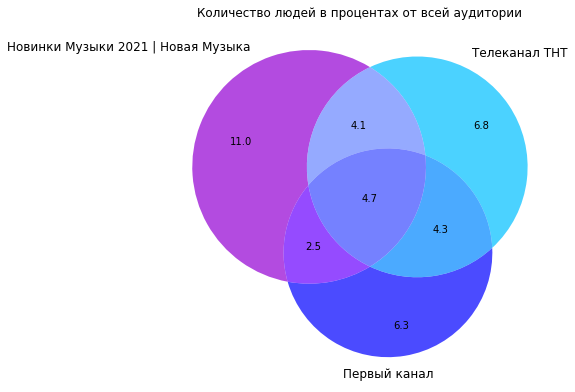

In [219]:
total_users = df_groups['id'].nunique()

sets = Counter()               #set order A, B, C   
sets['100'] = round(100*len(A_rest)/total_users,1)     #100 denotes A on, B off, C off 
sets['010'] = round(100*len(B_rest)/total_users,1)     #010 denotes A off, B on, C off
sets['001'] = round(100*len(C_rest)/total_users,1)      #001 denotes A off, B off, C on 
sets['110'] = round(100*len(AB_only)/total_users,1)     #110 denotes A on, B on, C off
sets['101'] = round(100*len(AC_only)/total_users,1)     #101 denotes A on, B off, C on 
sets['011'] = round(100*len(BC_only)/total_users, 1)     #011 denotes A off, B on, C on 
sets['111'] = round(100*len(ABC_overlap)/total_users,1) #011 denotes A on, B on, C on

labels = ('Новинки Музыки 2021 | Новая Музыка', 'Телеканал ТНТ', 'Первый канал')  
plt.figure(figsize=(7,7)) 
ax = plt.gca() 
venn3(subsets=sets, 
      set_labels=labels, 
      ax=ax,
      set_colors=('darkviolet','deepskyblue','blue'),
      alpha=0.7)  
plt.title('Количество людей в процентах от всей аудитории')
plt.show()

### Русская Музыка - Телеканал ТНТ - Первый канал

In [220]:
AB_overlap = group_set_5 & group_set_3  #compute intersection of set A & set B
AC_overlap = group_set_5 & group_set_4
BC_overlap = group_set_3 & group_set_4
ABC_overlap = group_set_5 & group_set_3 & group_set_4

A_rest = group_set_5 - AB_overlap - AC_overlap #see left graphic
B_rest = group_set_3 - AB_overlap - BC_overlap
C_rest = group_set_4 - AC_overlap - BC_overlap

AB_only = AB_overlap - ABC_overlap   #see right graphic
AC_only = AC_overlap - ABC_overlap
BC_only = BC_overlap - ABC_overlap

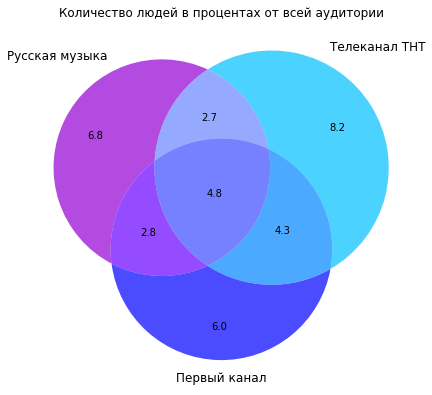

In [221]:
total_users = df_groups['id'].nunique()

sets = Counter()               #set order A, B, C   
sets['100'] = round(100*len(A_rest)/total_users,1)     #100 denotes A on, B off, C off 
sets['010'] = round(100*len(B_rest)/total_users,1)     #010 denotes A off, B on, C off
sets['001'] = round(100*len(C_rest)/total_users,1)      #001 denotes A off, B off, C on 
sets['110'] = round(100*len(AB_only)/total_users,1)     #110 denotes A on, B on, C off
sets['101'] = round(100*len(AC_only)/total_users,1)     #101 denotes A on, B off, C on 
sets['011'] = round(100*len(BC_only)/total_users, 1)     #011 denotes A off, B on, C on 
sets['111'] = round(100*len(ABC_overlap)/total_users,1) #011 denotes A on, B on, C on

labels = ('Русская музыка', 'Телеканал ТНТ', 'Первый канал')  
plt.figure(figsize=(7,7)) 
ax = plt.gca() 
venn3(subsets=sets, 
      set_labels=labels, 
      ax=ax,
      set_colors=('darkviolet','deepskyblue','blue'),
      alpha=0.7)  
plt.title('Количество людей в процентах от всей аудитории')
plt.show()